In [1]:
from tqdm import tqdm
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

from blackjackenv_extended import BlackjackEnv
from random_agent import RandomAgent
from basic_strategy_agent import BasicStrategyAgent
from backprop_agent import BackpropAgent
from FFNN_agent import FFNNAgent
from DQFFNN_BJ_agent import DQFFNNAgentBJ
from DQFFNN_agent import DQFFNNAgent

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("using gpu: ", torch.cuda.get_device_name())
else:
    device = torch.device('cpu')
    print("using cpu")

using cpu


In [11]:
KEY = {0: 'STAND', 1:'HIT', 2:'DOUBLE', 3: 'SPLIT'}


def play_game(env, episodes, agent, collect_data=False):
    rewards = []

    for episode in tqdm(range(episodes)):
        observation, info = env.reset()
        done = False
        
        # print(f"Episode: {episode+1}/{episodes}")
        # print("-"*40)
        # print("hand 1", env.player)
        # print("hand 2", env.player2)
        # print("Start Observation: ", observation)
        
        
        while not done:
            
            action = agent.get_action(observation)
            #print("Action: ", KEY[action])

            # save data for training
            if collect_data:
                agent.collect_data(observation, action)
            
            next_observation, reward, terminated, truncated, info = env.step(action) 
            agent.learn(observation, action, reward, next_observation, terminated or truncated)
            observation = next_observation
            
            # print("hand 1", env.player)
            # print("hand 2", env.player2)
            # print("Observation: ", observation, "Reward: ", reward)
            

            if terminated or truncated:
                # print(f"Dealer hand: ", env.dealer)
                rewards.append(reward)
                observation = env.reset()
                done = True
        
        agent.decay_epsilon()    

    if collect_data:
        agent.save_data()
    
    average_reward = sum(rewards)/episodes
    variance = sum([((x - average_reward) ** 2) for x in rewards]) / (episodes - 1)

    #print("Rewards: ", rewards)
    print("Average Reward: ", average_reward)
    print("Variance: ", variance)
    
    return rewards

In [4]:
def plot_reward(data, title, filename):

    #data = np.array(data)

    rolling_length = 1000
    rolling_mean = np.convolve(data, np.ones(rolling_length)/rolling_length, mode='valid')

    plt.plot(rolling_mean)

    plt.ylabel("Reward")
    plt.xlabel("Episodes")
    plt.title(title)
    plt.savefig(f"../data/{filename}.png", dpi='figure', format=None)
    plt.show()

## Random & Basic Agents

In [5]:
env = BlackjackEnv(natural=True)

# Hyperparameters
episodes = 2
collect_data = False

100%|██████████| 3000/3000 [00:00<00:00, 6992.89it/s]


Average Reward:  -0.5113333333333333
Variance:  1.493536067578062


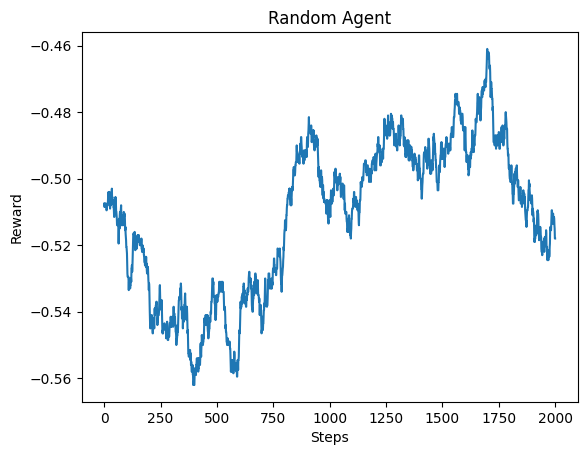

100%|██████████| 3000/3000 [00:00<00:00, 7488.80it/s]


Average Reward:  -0.006666666666666667
Variance:  1.2863843503390355


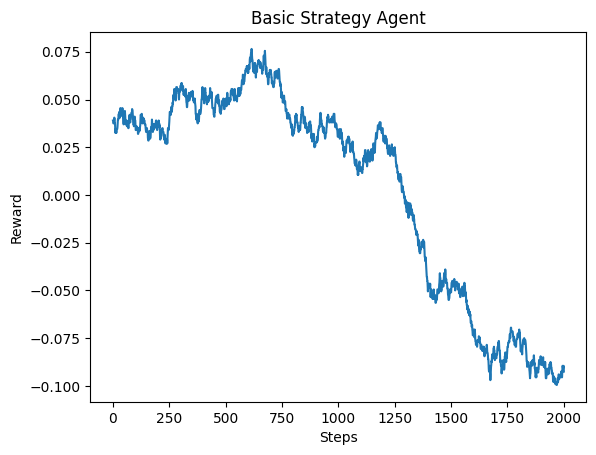

In [11]:
agent = RandomAgent(env, filename="random_agent")
rewards_random = play_game(env, episodes, agent, collect_data)
plot_reward(rewards_random, "Random Agent", "random_agent")

agent = BasicStrategyAgent(env, filename="basic_strategy_agent")
rewards_basic_strategy = play_game(env, episodes, agent, collect_data)
plot_reward(rewards_basic_strategy, "Basic Strategy Agent", "basic_strategy_agent")

## FFNN & Backpropagation

In [ ]:
# FFNN hyperparameters
model_path = '../models/best_model.pth'
layers = [9,100,100]
threshold = 3
lr = 0.01

agent = FFNNAgent(
    env,
    model_path=model_path,
    device=device,
    layers=layers,
    threshold=threshold,
    lr=lr,
    filename="ffnn_agent"
)

rewards_FFNN = play_game(env, episodes, agent, collect_data)
plot_reward(rewards_FFNN, "FFNN Agent", "ffnn_agent")

100%|██████████| 3000/3000 [00:01<00:00, 2601.29it/s]


Average Reward:  -0.0028333333333333335
Variance:  1.2835031399355321


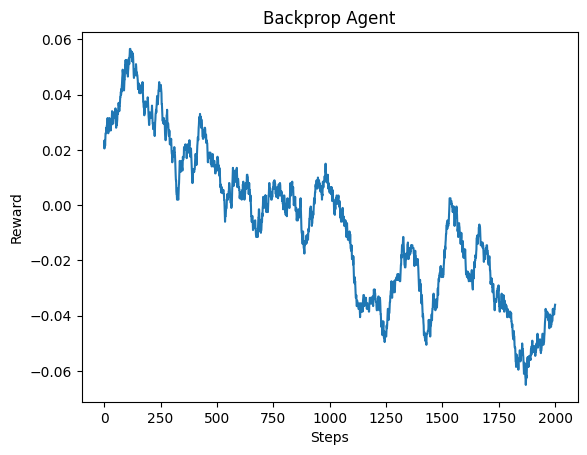

In [7]:
# Backprop hyperparameters
input_size = 5
output_size = 4
hidden_size = 30
activation_fn = nn.ReLU()

agent = BackpropAgent(
    env, 
    model=torch.load('../models/backprop_model.pth'),
    input_size=input_size, 
    output_size=output_size, 
    hidden_size=hidden_size, 
    activation_fn=activation_fn,
    filename="backprop_agent"
)

rewards_FFNN = play_game(env, episodes, agent, collect_data)
plot_reward(rewards_FFNN, "Backprop Agent", "backprop_agent")

## DQFFNN

100%|██████████| 3000/3000 [00:23<00:00, 130.25it/s]


Average Reward:  -0.2855
Variance:  1.1076089529843487


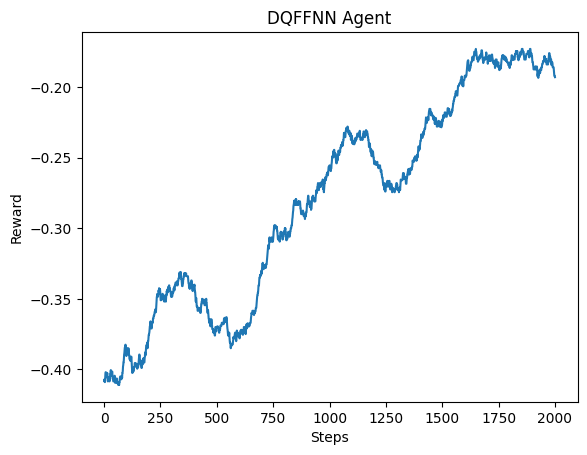

In [10]:
# DQFFNN hyperparameters
layers = [9,100,100]
threshold = 3
lr = 0.01

epsilon = 1.0
epsilon_decay = epsilon / (episodes / 2)
discount_factor = 0.99
batch_size = 5
update_td_target = 50
buffer_size = 100000

agent = DQFFNNAgentBJ(
    env,
    device=device,
    layers=layers,
    threshold=threshold,
    lr=lr,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    discount_factor=discount_factor,
    batch_size=batch_size,
    update_td_target=update_td_target,
    buffer_size=buffer_size,
    filename="dqffnn_agent"
)

#agent.model.save_model(path='../models/DQFFNN_model.pth')
rewards_DQFFNN = play_game(env, episodes, agent, collect_data)
plot_reward(rewards_DQFFNN, "DQFFNN Agent", f"DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}")

### Cartpole

In [13]:
env = gym.make("CartPole-v1", render_mode="human")

layers = [6,200,200,200]
threshold = 0.5
lr = 0.01

epsilon = 1.0
epsilon_decay = epsilon / (episodes / 2)
discount_factor = 0.99
batch_size = 5
update_td_target = 50
buffer_size = 100000

agent = DQFFNNAgent(
    env,
    device=device,
    layers=layers,
    threshold=threshold,
    lr=lr,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    discount_factor=discount_factor,
    batch_size=batch_size,
    update_td_target=update_td_target,
    buffer_size=buffer_size
)

agent.model.save_model(path='../models/Cartpole_DQFFNN_model.pth')
rewards = play_game(env, episodes, agent, False)
plot_reward(rewards, "Cartpole", f"Cartpole_DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}")

  2%|▏         | 46/3000 [00:23<25:29,  1.93it/s] 


KeyboardInterrupt: 